In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('Tasla_Stock.csv')
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [9]:
data = df.filter(['Close'])
dataset = data.values

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

## Train Data preparation

In [12]:
training_data_len = math.ceil(len(dataset) * 0.8)
train_data = scaled_data[0:training_data_len, :]

In [13]:
x_train = []
y_train = []
time_step = 60  

for i in range(time_step, len(train_data)):
    x_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train.shape

(1760, 60)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create the Testing Dataset

In [19]:
test_data = scaled_data[training_data_len - time_step: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(time_step, len(test_data)):
    x_test.append(test_data[i-time_step:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [38]:
y_test_scaled = scaled_data[training_data_len:, :]

In [20]:
print("Training Data Shape:", x_train.shape)
print("Testing Data Shape:", x_test.shape)

Training Data Shape: (1760, 60, 1)
Testing Data Shape: (454, 60, 1)


# Model Building

In [34]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x_train, 
    y_train, 
    batch_size=64, 
    epochs=50, # Set a high max, let early stopping handle the stop
    validation_data=(x_test, y_test_scaled),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.9995e-04 - val_loss: 0.0029
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.4058e-04 - val_loss: 0.0029
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.0178e-04 - val_loss: 0.0031
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.6465e-04 - val_loss: 0.0026
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.3657e-04 - val_loss: 0.0028
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.7555e-04 - val_loss: 0.0024
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.3846e-04 - val_loss: 0.0024
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.3658e-04 - val_loss: 0.0022
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.9382e-04 - val_loss: 0.0021
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.6580e-04 - val_loss: 0.0020
Epoch 12/50
28/28 ━━━━━

## Predictions

In [43]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [44]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")

RMSE: 11.59639024207058


# Visualize Results

In [45]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28856\2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


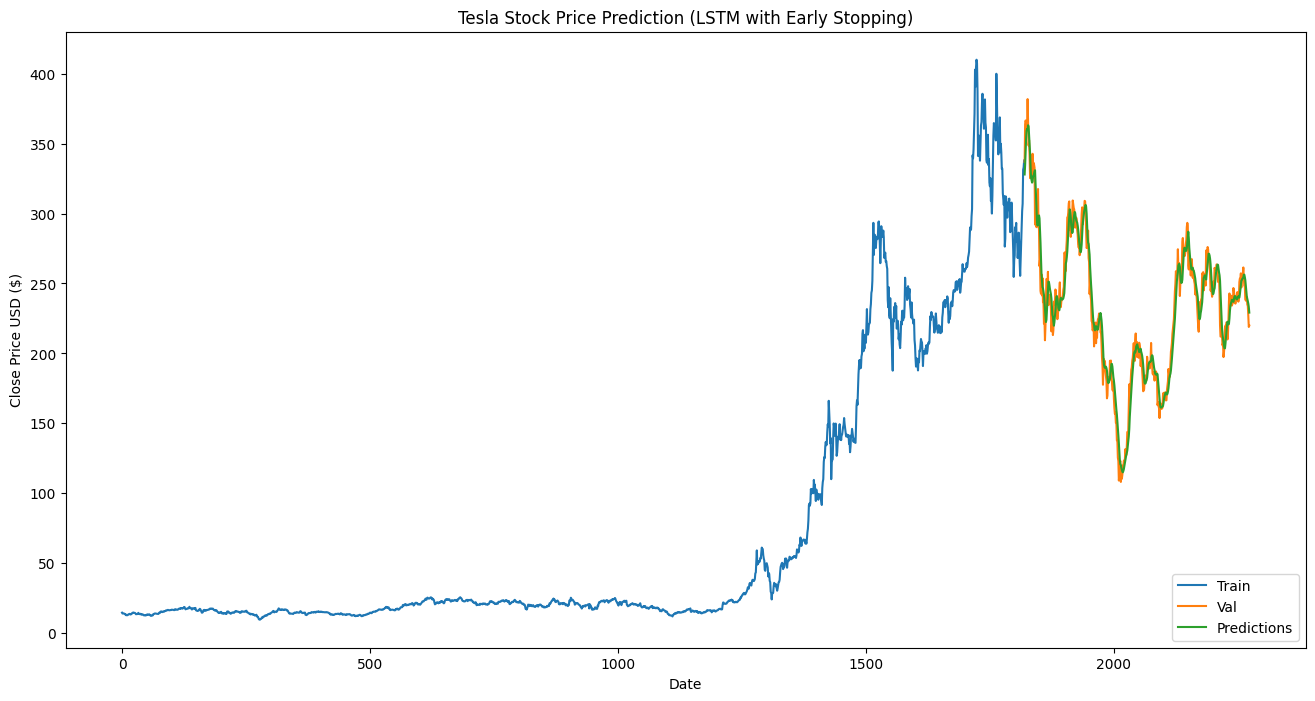

In [46]:
plt.figure(figsize=(16,8))
plt.title('Tesla Stock Price Prediction (LSTM with Early Stopping)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#### Plot the training loss vs validation loss

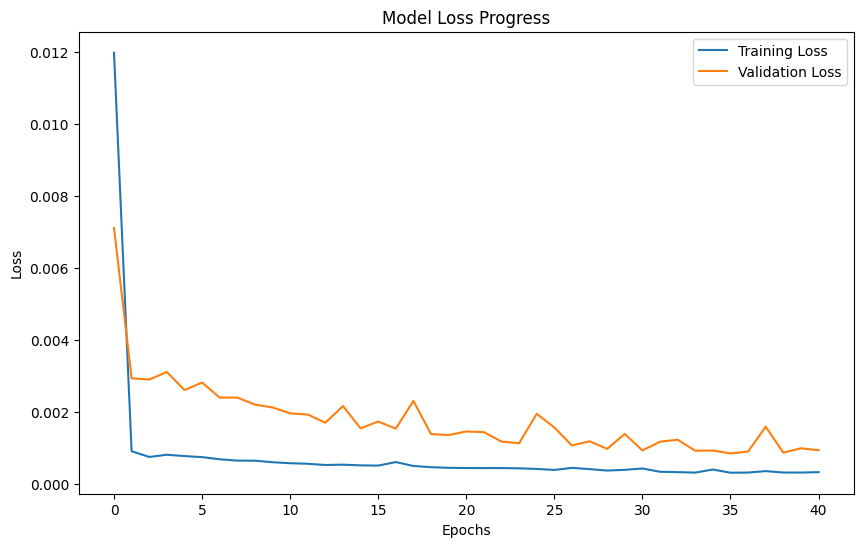

In [47]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save the model and the scaler

In [48]:
import joblib

# 1. Save the Keras Model
model.save('stock_prediction_model.keras')

# 2. Save the Scaler
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
